In [2]:
# written by Jade Chongsathapornpong, Jan. 2023
# MCSC Climate Scholars Program, Tuller Group, MIT
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import lmfit

import os

# Fitting Electrochemical Impedance Spectra
In this experiment with a thin film sample, our structure is (Pt interdigitated electrodes) stacked on (conductive sample material thin film) on a (dielectric substrate, e.g. alumina). One can model it as an offset resistance $R_1$ in series with an RC tank circuit $R_2$ with capacitance $C$. Practically, the non-idealities of the capacitance can be lumped as a constant phase element, which has impedance
\begin{equation}
    Z_{CPE} = \frac{1}{Q_0\omega^n}e^{-\frac{i \pi n}{2}},\quad n\in(0.5, 1)
\end{equation}
and of course the ideal resistances have impedance $Z=R$. From AC circuit theory, series impedances add, and parallel impedances obey
\begin{equation}
    Z_{parallel} = \frac{Z_1Z_2}{Z_1 + Z_2}
\end{equation}

So we find the total (frequency-dependent) impedance is
\begin{equation}
    Z_{eq} = R_1 + \frac{R_2}{R_2 Q_0 \omega^n e^{\frac{i\pi n}{2}} + 1}
\end{equation}
which with $Z = R + iX$ we can break into real and imaginary components:
\begin{equation}
    R = R_1 + \frac{R_2 + R_2^2Q_0\omega^n\cos\frac{\pi n}{2}}{R_2^2Q_0^2\omega^{2n}\sin^2\left(\frac{\pi n}{2}\right) + (R_2Q_0\omega^n\cos\left(\frac{\pi n}{2}\right) + 1)^2}
\end{equation}
and
\begin{equation}
    iX = \frac{-iR_2^2Q_0\omega^n\sin\left(\frac{\pi n}{2}\right)}{R_2^2Q_0^2\omega^{2n}\sin^2\left(\frac{\pi n}{2}\right) + (R_2Q_0\omega^n\cos\left(\frac{\pi n}{2}\right) + 1)^2}
\end{equation}
We're most interested in the resistance $R_2$, which should correspond to that of the sample thin film (since the parallel substrate has much larger resistance). To extract this from our data, we'll need to fit for the parameters in the above.

My approach will be to perform a simultaneous fit for the real and imaginary components of the impedance as a function of frequency, in line with [https://pollackscience.github.io/multidim-fits.html](https://pollackscience.github.io/multidim-fits.html). It's likely there's a better way to do this, but this is what first came to mind.

Let's bring in the data.

In [3]:
# filenames # observed resistivity
root = r"PCO10_4k\Impedance"
fn475 = os.path.join(root, "475C.csv") # 22.362512174262104 Ohm-meters
fn500 = os.path.join(root, "500C.csv") # 15.642774806763246 Ohm-meters
fn525 = os.path.join(root, "525C_1.csv") # 15.139390129901546 Ohm-meters      # are we sure this was actually 525C, not 500C?
fn525_2 = os.path.join(root, "525C_2.csv") # 11.029822121340631 Ohm-meters
fn550 = os.path.join(root, "550C.csv") # 7.3432983984480185 Ohm-meters

In [4]:
current_datafile = fn550
# example read
df = pd.read_csv(current_datafile)
df

Experiment:   Impedance
Start date:  Thursday            November 17        2022
Start time:  3:29:19 PM -05:00           NaN         NaN
Time (s)     Frequency (Hz)         Z' (Ohm)   Z'' (Ohm)
2601         1000000                9499.934   -23100.82
             794328.2               12893.36   -30667.91
...                                      ...         ...
2660         0.1                    383531.6   -9472.818
2673         0.079433               384936.1   -10602.43
2689         0.063096               386508.5   -11843.51
2709         0.050119               388268.2   -13133.62
2729         0.05                   388521.3   -13160.94

[78 rows x 2 columns]

Note that in these data (produced by a Solartron ECS impedance analyzer), $R=Z'$ and $X=Z''$. Now, we should convert these frequencies, resistances, and reactances into standalone columns, to use with `lmfit`. I'll just skip the first few rows that give metadata for this.

In [ ]:
df = pd.read_csv(current_datafile, skiprows=3)
df["Frequency (rad/s)"] = df[" Frequency (Hz)"] * 2 * np.pi
print(df.keys()) # should give us the columns we want
#df[" Z'' (Ohm)"] = -df[" Z'' (Ohm)"]

To make sure this is loaded correctly, let's make our Bode and Nyquist plots.

In [ ]:
# Nyquist plot
plt.title(f"Nyquist Plot: {current_datafile}")
plt.scatter(df[" Z' (Ohm)"], df[" Z'' (Ohm)"])
plt.xlabel("Z'")
plt.ylabel("Z''")
plt.axis('square')
plt.show()

# Bode plot
fig, ax = plt.subplots()
ax.set_title(f"Bode Plot: {current_datafile}")
ax.scatter(df[' Frequency (Hz)'], df[" Z' (Ohm)"], label='Re(Z)')
ax.scatter(df[' Frequency (Hz)'], df[" Z'' (Ohm)"], label='Im(Z)')
ax.set_xlabel("Frequency (Hz)")
ax.legend()
plt.show()

Provided that this looks right, we'll go ahead and fit $\Re(Z)$ and $\Im(Z)$ to the functional forms from earlier, i.e.
\begin{equation}
    R = R_1 + \frac{R_2 + R_2^2Q_0\omega^n\cos\frac{\pi n}{2}}{R_2^2Q_0^2\omega^{2n}\sin^2\left(\frac{\pi n}{2}\right) + (R_2Q_0\omega^n\cos\left(\frac{\pi n}{2}\right) + 1)^2}
\end{equation}
and
\begin{equation}
    X = \frac{-R_2^2Q_0\omega^n\sin\left(\frac{\pi n}{2}\right)}{R_2^2Q_0^2\omega^{2n}\sin^2\left(\frac{\pi n}{2}\right) + (R_2Q_0\omega^n\cos\left(\frac{\pi n}{2}\right) + 1)^2}
\end{equation}
with $R_1$, $R_2$, $Q_0$, and $n$ being the parameters, and $\omega$ the one independent variable.

We have essentially an array of 2D vectors that we're fitting here, i.e. for each frequency there is a real and imaginary component.

In [ ]:
# here, x is an array of frequencies omega
def impedance_2d(x: np.ndarray, R1: float, R2: float, Q: float, n: float) -> np.ndarray:
    # calculate common denominator for each omega
    theta = 0.5*n*np.pi
    denom1 = R2**2 * Q**2 * (np.sin(theta))**2 * np.power(x, 2*n)
    denom2 = ((R2 * Q * np.cos(theta) * np.power(x, n)) + 1)**2
    denom = denom1 + denom2
    # calculate the real and imaginary part for each omega
    Re = R1 + (R2 + R2**2 * Q * np.cos(theta) * np.power(x, n))/denom
    Im = (-R2**2 * Q * np.sin(theta) * np.power(x, n))/denom
    # return as one concatenated array of length 2*len(x)
    return np.concatenate([Re, Im])

In [ ]:
guess = (1000, 400000, 5e-12) # user-provided guess based on the data plots, format (R1, R2, Q)
"""NOTE: levenberg-marquadt is good, but you need to be somewhat close on these values.
R1 can be estimated from the horizontal offset of the semicircle, R2 the intercept at low frequency,
and you should play around with Q over different orders of magnitude. 2e-11 worked well for PCO10_4k at 525+C"""

# We define our model and tell it which inputs are independent variables
model = lmfit.Model(impedance_2d, independent_vars=['x'])
# Now we can define our free parameters and initialize them.
params = lmfit.Parameters()
params.add('R1', value=guess[0], min=0)
params.add('R2', value=guess[1], min=0)
params.add('Q', value=guess[2])
params.add('n', value=0.9, min=0.5, max=1.0)

In [ ]:
# Next, we take our data and concatenate it in the same format as impedance_2d outputs
samples = np.concatenate((df[" Z' (Ohm)"].values, df[" Z'' (Ohm)"].values))
# and call Model.fit
result = model.fit(samples, x=df["Frequency (rad/s)"].values, params=params)

print(result.fit_report())

In [ ]:
# Plot the resulting fit
impedance_eval = result.eval(x=df["Frequency (rad/s)"].values).reshape(2, -1)
df["Fit Re"] = impedance_eval[0]
df["Fit Im"] = impedance_eval[1]

# Nyquist plot
plt.title(f"Nyquist Plot: {current_datafile}")
plt.scatter(df[" Z' (Ohm)"], df[" Z'' (Ohm)"], label="data")
plt.plot(df["Fit Re"], df["Fit Im"], label="best fit")
plt.xlabel("Z'")
plt.ylabel("Z''")
plt.axis('square')
plt.legend()
plt.show()

# Bode plot
fig, ax = plt.subplots()
ax.set_title(f"Bode Plot: {current_datafile}")
ax.scatter(df['Frequency (rad/s)'], df[" Z' (Ohm)"], label='Re(Z)')
ax.scatter(df['Frequency (rad/s)'], df[" Z'' (Ohm)"], label='Im(Z)')
ax.set_xlabel("Frequency (rad/s)")
ax.set_ylabel("Impedance (Ohm)")
ax.plot(df['Frequency (rad/s)'], df["Fit Re"], label='Re(Z) fit')
ax.plot(df['Frequency (rad/s)'], df["Fit Im"], label='Im(Z) fit')
ax.legend()
plt.show()

After fiddling with the initial parameters (there's probably some algorithm out there to guess them from the data), we get a nice looking fit! It remains to deduce uncertainties on these parameters (or take the $\Delta\chi^2_\nu = 1$ result from `lmfit` at face value), but I'll leave that for the future when we actually want to report results. Our next step will be to account for geometric factors, to correspond these parameters to material properties (especially film resistivity).

# Deconvoluting Geometry
For our current experimental series, we use interdigitated electrodes, which when "unwrapped" are approximately equivalent to two 70mm-long linear electrodes with 0.3mm of our material in between them. There are uncertainties here, namely:
- The "unwrapped" electrodes don't actually have material in between them, but are rather sitting on top of them. On average, this means the mean path length through the material for current to travel is actually greater than 0.3mm, and thus we overestimate resistivity from the observed $R_2$. This is at most by half of the width of an electrode, which is maybe 0.15mm, but biased to be smaller due to longer paths contributing less. This yields a relatively large asymmetric systematic uncertainty in our resistivity, but to be consistent with Han Gil's measurements we ignore this. A numerical study, or using thinner "fingers" of the electrode, would correct/reduce this uncertainty, respectively.
- Due to the sample construction, there are additional paths for current to take through the material, other than the well-defined 0.3mm gaps. We assume these are negligible (<1%).
- We aren't actually sure of the thickness of the material film, but extrapolating from other samples our PCO10_4k should be 85nm thick.

On further reflection, these probably dominate any uncertainties from the data fitting procedure, so we can likely ignore those.

Anyhow, resistivity given a cross-sectional area $A$, a path length $l$, and a resistance $R$, is
\begin{equation}
    \rho = R\frac{A}{l}
\end{equation}
and so estimating it is pretty simple, given our assumptions. $A$ is 85nm x 70mm, and $l$ is 0.3mm. Here, $R$ is $R_2$ from before.

In [ ]:
result.params

In [ ]:
# feed in distances in meters
A = 85e-9 * 70e-3
l = 0.3e-3
rho = result.params['R2'] * A / l
print("Resistivity (Ohm * meter):", rho)

# Extracting Carrier Activation Energies
In intrinsic semiconductors, the carrier concentration is like a Boltzmann distribution at that temperature, involving the intrinsic carrier activation energy. At sufficiently high temperature the metal oxides should have a significant population of intrinsic thermally excited electrons.

The measured resistance will decrease proportionally with increasing carrier concentration, assuming mobility remains similar (over our temperature range, I imagine effects like phonon scattering should not change all too much). This leads to
\begin{equation}
    \rho \propto \exp\left(\frac{E_A}{2k_BT}\right)
\end{equation}

### correction:
Thomas Defferriere: "The equation is relevant for intrinsic semiconductors with delocalized electrons, excited through the band gap. However for our wide band gap metal oxides this is not exactly the case. The electron concentration is typically controlled by the amount of ionic defects present in the lattice either due to the dopants and/or due to processing history. ( for example, in Pr doped CeO2 , \[Pr3+\]=2\[Vo2+\] and Pr3+= Pr4+ + e’ where Oo = Vo2+ + 2e’ + (1/2)O2 ). Assuming quenched in conditions and frozen electron concentration, then"
\begin{equation}
\sigma \propto \frac{1}{T}\exp\left(-\frac{H_{m, M_{\rm{Ce}}}}{k_BT}\right)
\end{equation}

(where $H_{m, M_{\rm{Ce}}}$ is (I think) the enthalpy for electrons (in small polarons) hopping.)

### correction 2:
Han Gil: we should fit
\begin{equation}
    \sigma \propto \exp\left(\frac{-E_A}{k_BT}\right)
\end{equation}

### clarification 3:
Thomas: There should in fact be the $1/T$ factor, but in our case the simple Arrhenius relation should be a good enough approximation.

conductivity: [0.00044717 0.00063926 0.00066055 0.00090662 0.00136184]
natural log: [-7.71257799 -7.35519372 -7.32244438 -7.00578902 -6.59891766]


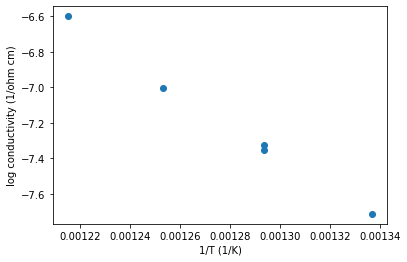

In [5]:
rho = np.array([22.363, 15.643, 15.139, 11.030, 7.343]) # Ohm-meters, manually entered from using the above code on each dataset
rho_cm = rho * 100
sigma = 1 / rho
sigma_cm = 1 / rho_cm
ln_sigma_cm = np.log(sigma_cm)
T = np.array([475, 500, 500, 525, 550]) + 273 # Kelvin, I switched one of the 525s to 500, since it may have been a typo
invT = 1/T
plt.scatter(invT, ln_sigma_cm)
plt.xlabel("1/T (1/K)")
plt.ylabel("log conductivity (1/ohm cm)")
print("conductivity:", sigma_cm)
print("natural log:", ln_sigma_cm)
plt.show()

E: 0.7792134559523798


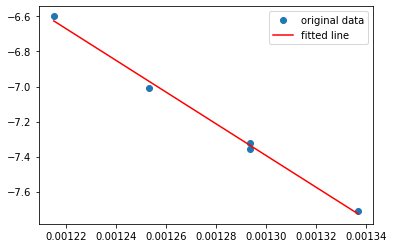

In [6]:
res = scipy.stats.linregress(invT, ln_sigma_cm)
plt.plot(invT, ln_sigma_cm, 'o', label='original data')
plt.plot(invT, res.intercept + res.slope*invT, 'r', label='fitted line')
kB = 8.617333262e-5 # eV/K
print("E:", -res.slope * kB)
plt.legend()
plt.show()

In [7]:
"""This is likely NOT the correct model; use the one for conductivity given by Thomas instead. I'm leaving it here for posterity."""
def resistivity(x, E, A):
    # x is absolute temperature (K) and E is activation energy (eV), returns resistivity in Ohm meters
    kB = 8.617333262e-5 # eV/K
    return A * np.exp(E / (kB*x))

model_rho = lmfit.Model(resistivity, independent_vars=['x'])
params_rho = lmfit.Parameters()
params_rho.add('E', value=1, min=1e-19)
params_rho.add('A', value=100)

[[Model]]
    Model(resistivity)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 5
    # variables        = 2
    chi-square         = 0.33820593
    reduced chi-square = 0.11273531
    Akaike info crit   = -9.46769107
    Bayesian info crit = -10.2488152
    R-squared          = 0.99732881
[[Variables]]
    E:  0.75814001 +/- 0.02480033 (3.27%) (init = 1)
    A:  1.7501e-04 +/- 6.5728e-05 (37.56%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(E, A) = -1.000


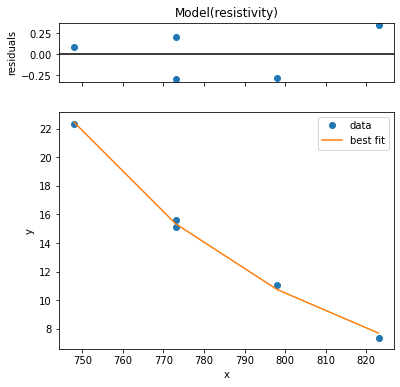

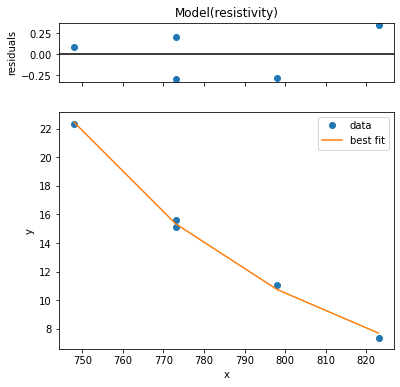

In [8]:
"""This is likely NOT the correct model; use the one for conductivity given by Thomas instead. I'm leaving it here for posterity."""
resultr = model_rho.fit(rho, x=T, params=params_rho)
print(resultr.fit_report())
resultr.plot()

In [9]:
def conductivity_thomas(x, E, A):
    # x is absolute temperature (K) and E is activation energy (eV), returns conductivity in (Ohm meters)^{-1}
    kB = 8.617333262e-5 # eV/K
    return (A / x) * np.exp(-E / (kB * x))

model_sig = lmfit.Model(conductivity_thomas, independent_vars=['x'])
params_sig = lmfit.Parameters()
params_sig.add('E', value=0.1, min=1e-19)
params_sig.add('A', value=100)

[[Model]]
    Model(conductivity_thomas)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 198
    # data points      = 5
    # variables        = 2
    chi-square         = 2.1563e-05
    reduced chi-square = 7.1875e-06
    Akaike info crit   = -57.7699467
    Bayesian info crit = -58.5510709
    R-squared          = 0.99565936
[[Variables]]
    E:  0.87394763 +/- 0.03207208 (3.67%) (init = 0.1)
    A:  24893465.1 +/- 11566287.0 (46.46%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(E, A) = 1.000


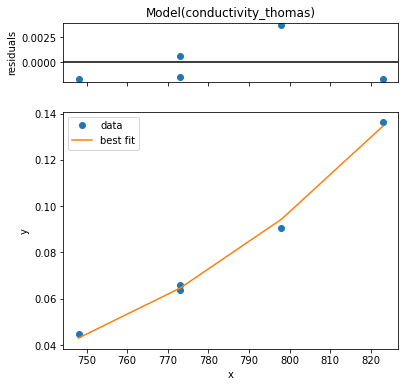

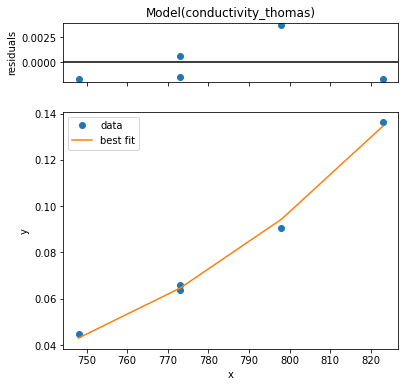

In [10]:
resultc = model_sig.fit(sigma, x=T, params=params_sig)
print(resultc.fit_report())
resultc.plot()

In [11]:
def conductivity(x, E, A):
    kB = 8.617333262e-5 # eV/K
    return A * np.exp(-E / (kB * x))

model_a = lmfit.Model(conductivity, independent_vars=['x'])
params_a = lmfit.Parameters()
params_a.add('E', value=1, min=1e-19)
params_a.add('A', value=10)

[[Model]]
    Model(conductivity)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 121
    # data points      = 5
    # variables        = 2
    chi-square         = 2.0996e-05
    reduced chi-square = 6.9987e-06
    Akaike info crit   = -57.9030666
    Bayesian info crit = -58.6841908
    R-squared          = 0.99577340
[[Variables]]
    E:  0.80561634 +/- 0.03163629 (3.93%) (init = 1)
    A:  11543.3375 +/- 5290.54087 (45.83%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(E, A) = 1.000


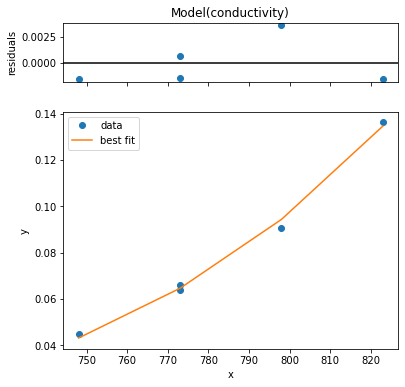

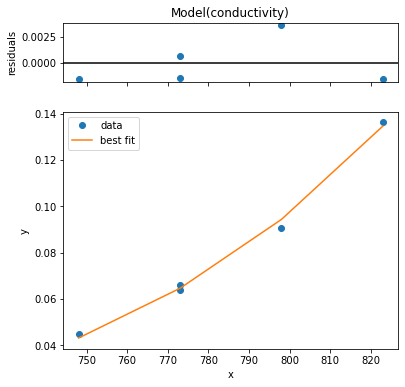

In [12]:
resulta = model_a.fit(sigma, x=T, params=params_a)
print(resulta.fit_report())
resulta.plot()

### Result
All in all, we get for our PCO10-4k pulse sample an activation energy of $0.87\pm0.04_{\rm{stat}}$eV using Thomas' functional form, though additional uncertainty is not properly estimated (see discussion in "Deconvoluting Geometry" for some sources of uncertainty). If I recall correctly, the literature value from Nicollet et al. was $1.06$eV. Our value is not outlandish, but at face value has statistically significant disagreement.

Fitting the Arrhenius relation directly as Han Gil suggests, yields $0.78$eV (linear regression in semilog space) or $0.81\pm0.03_{\rm{stat}}$eV, which is somewhat lower still.

Thomas and Han Gil note that the small polaron hopping process alone will yield an activation energy of around $0.4$eV when fitting the conductivity change against temperature, arising from change in mobility. Meanwhile, there is another contribution to the temperature dependence of conductivity, arising from the change in carrier concentrations as the defect equilibrium shifts. We suspect the surface exchange was poisoned, meaning that the defect populations would be slow to equilibrate. Thomas suggests that our lower activation energy corresponds to this fact, since the temperature-dependence of the conductivity in that case is mostly from the change in small polaron mobility at $0.4$eV.

It's worth noting that this "activation energy" does not correspond to the activation energy barrier of any one particular process, but is rather a combination of all these contributions to temperature-dependent conductivity. I was confused about this for a long time. 